<center>
    <h1>Induce Sparsity in Online Learning Linear Models</h1>
</center>

In this notebook we are going to explore sparse regularization in the specific regime of online learning. As opposed to batch learning, the machine learning model is updated one sample at a time. That specificity involves noisy approximates of the true gradients which easily move away weights from zero.

Experiments will consist of testing different methods applied to a linear regression trained with SGD. For $p$ being the number of features, the model equation is defined as:

$$
\normalsize
\hat{y}(x) = w_{0} + \sum_{j=1}^{p} w_{j} x_{j}
$$

Squared loss will be minimized:

$$
\normalsize
L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2
$$

Let's create a synthetic dataset of 10,000 samples, 10 informative features, and 90 noisy features.

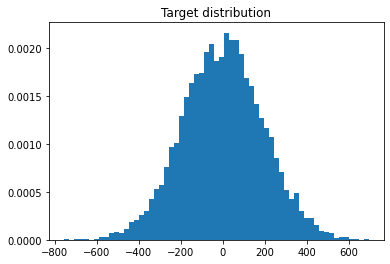

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets

X, y = datasets.make_regression(n_samples=10_000, n_features=100, n_informative=10, noise=5, random_state=22)

# Transform each sample to a dict
X = [dict(enumerate(x)) for x in X]

# Init a dict to store trained weights
trained_weights = {}

# Plot target distribution
plt.hist(y, density=True, bins='auto')
plt.title('Target distribution')
plt.show()

Define the training procedure.

In [2]:
from sklearn.metrics import mean_absolute_error

def train(model):
    # Training loop
    y_pred = []
    for x, yi in zip(X, y):
        y_pred.append(model.predict_one(x))
        _ = model.learn_one(x, yi)

    # Display MAE
    mae = mean_absolute_error(y, y_pred)
    print(f'MAE = {mae:.1f}\n')
    
    return model

## 1. No regularization

Without any regularization, weights update consists of:

$$
\normalsize
\begin{align*}
    w^{t+1}_j &= w^{t}_j - \eta \frac{\partial L}{\partial w^{t}_j} \\
    w^{t+1}_j &= w^{t}_j - \eta (-x_j(y - \hat{y}))
\end{align*}
$$

Where $\eta$ is the learning rate.

In [3]:
import collections

class LinearRegression:
    
    def __init__(self, intercept=0, l1_reg=.1, learning_rate=.01):
        self.intercept = intercept
        self.l1_reg = l1_reg
        self.learning_rate = learning_rate
        self.weights = collections.defaultdict(float)
    
    def _update_weights(self, x, loss_gradient):
        for j, xj in x.items():
            self.weights[j] = self.weights[j] + self.learning_rate * xj * loss_gradient
    
    def learn_one(self, x, y):
        y_hat = self.predict_one(x)
        loss_gradient = y - y_hat
        
        # Update the intercept and the weights
        self.intercept = self.intercept + self.learning_rate * loss_gradient
        self._update_weights(x, loss_gradient)
        
        return self
    
    def predict_one(self, x):
        return self.intercept + sum((xj * self.weights[j] for j, xj in x.items()))

Train a model without any regularization.

In [4]:
%%time

model = train(LinearRegression())

# Store trained weights
trained_weights['No regularization'] = list(model.weights.values())

MAE = 8.2

CPU times: user 829 ms, sys: 3.89 ms, total: 833 ms
Wall time: 832 ms


## 2. L1 naive

Let's apply a naive L1 penalty as it is common in the batch setting:

$$
\normalsize
\begin{align*}
    w^{t+1}_j &= w^{t}_j - \eta \frac{\partial}{\partial w^{t}_j}(L(y, \hat{y}) + \lambda ||w||_1) \\ \\
    w^{t+1}_j &=
    \begin{cases}
      w^{t}_j - \eta (-x_j(y - \hat{y}) + \lambda), & \text{if}\ w_j > 0 \\
      w^{t}_j - \eta (-x_j(y - \hat{y}) - \lambda), & \text{if}\ w_j < 0 \\
      w^{t}_j - \eta (-x_j(y - \hat{y})), & \text{otherwise}
    \end{cases}
\end{align*}
$$

Where $\lambda$ is the amount of L1 regularization applied.

In [5]:
class L1Naive(LinearRegression):
    
    def _sign(self, z):
        return -1 if z < 0 else (1 if z > 0 else 0)
    
    def _update_weights(self, x, loss_gradient):
        for j, xj in x.items():
            wj = self.weights[j]
            l1 = self.l1_reg * self._sign(wj)
            self.weights[j] = wj + self.learning_rate * (xj * loss_gradient + l1)

Train a L1 naive model.

In [6]:
%%time

model = train(L1Naive())

# Store trained weights
trained_weights['L1 naive'] = list(model.weights.values())

MAE = 8.7

CPU times: user 1.53 s, sys: 3.68 ms, total: 1.53 s
Wall time: 1.53 s


## 3. L1 cumulative penalty

Proposed by [(Tsuruoka et al., 2009)](https://www.aclweb.org/anthology/P09-1054.pdf), "*the main idea is to keep track of the total penalty and the penalty that has been applied to each weight, so that the L1 penalty is applied based on the difference between those cumulative values*". Let $u_t$ be the absolute value of the total L1 penalty that each weight could have received up to the point:

$$
\normalsize
u_t = t \eta \lambda
$$

The weight updating method is defined as:

$$
\normalsize
\begin{align*}
    w^{t + \frac{1}{2}}_j &= w^{t}_j - \eta \frac{\partial L}{\partial w_j} \\ \\
    w^{t + 1}_j &=
    \begin{cases}
      max(0, w^{t + \frac{1}{2}}_j - (u_t + q^{t-1}_j)), & \text{if}\ w^{t + \frac{1}{2}}_j > 0 \\
      min(0, w^{t + \frac{1}{2}}_j + (u_t - q^{t-1}_j)), & \text{if}\ w^{t + \frac{1}{2}}_j < 0 \\
      w^{t + \frac{1}{2}}_j, & \text{otherwise}
    \end{cases}
\end{align*}
$$

With $q^{k}_j$ the total L1 penalty that $w_j$ has actually received up to the point:

$$
\normalsize
q^{k}_j = \sum_{t=1}^{k} (w^{t+1}_j - w^{t + \frac{1}{2}}_j)
$$

"*In effect, it forces the weight to receive the total L1 penalty that would have been applied if the weight had been updated by the true gradients, assuming that the current weight vector resides in the same orthant as the true weight vector*."

In [7]:
class L1Cumulative(LinearRegression):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.max_cum_l1 = 0
        self.cum_l1 = collections.defaultdict(float)

    def _update_weights(self, x, loss_gradient):
        self.max_cum_l1 = self.max_cum_l1 + self.l1_reg * self.learning_rate
        
        for j, xj in x.items():
            wj_temp = self.weights[j] + self.learning_rate * xj * loss_gradient
            if wj_temp > 0:
                self.weights[j] = max(0, wj_temp - (self.max_cum_l1 + self.cum_l1[j]))
            elif wj_temp < 0:
                self.weights[j] = min(0, wj_temp + (self.max_cum_l1 - self.cum_l1[j]))
            else:
                self.weights[j] = wj_temp
            
            self.cum_l1[j] = self.cum_l1[j] + (self.weights[j] - wj_temp)

Train a L1 cumulative model.

In [8]:
%%time

model = train(L1Cumulative())

# Store trained weights
trained_weights['L1 cumulative'] = list(model.weights.values())

MAE = 6.7

CPU times: user 2.46 s, sys: 0 ns, total: 2.46 s
Wall time: 2.46 s


## 4. Truncated gradient

It's a general method proposed by [(Langford et al., 2009)](https://hunch.net/~jl/projects/interactive/sparse_online/paper_sparseonline.pdf):

$$
\normalsize
\begin{align*}
    w^{t + \frac{1}{2}}_j &= w^{t}_j - \eta \frac{\partial L}{\partial w_j} \\ \\
    w^{t + 1}_j &=
    \begin{cases}
        max(0, w^{t + \frac{1}{2}}_j - \alpha, & \text{if}\ w^{t + \frac{1}{2}}_j \in [0, \theta] \\
        min(0, w^{t + \frac{1}{2}}_j + \alpha, & \text{if}\ w^{t + \frac{1}{2}}_j \in [- \theta, 0] \\
        w^{t + \frac{1}{2}}_j, & \text{otherwise}
    \end{cases}
\end{align*}
$$

With $\theta$ the bound delimiting the magnitude of the coefficients to regularize, and $\alpha$ the amount of regularization that can be applied at every $K$ step:

$$
\normalsize
\alpha =
\begin{cases}
    \eta K \lambda, & \text{if}\ t \mod K = 0 \\
    0, & \text{otherwise}
\end{cases}
$$

In [9]:
class TruncatedGradient(LinearRegression):
    
    def __init__(self, bound=3, k=10, **kwargs):
        super().__init__(**kwargs)
        self.n_iterations = 0
        self.bound = abs(bound)
        self.k = k

    def _update_weights(self, x, loss_gradient):
        self.n_iterations = self.n_iterations + 1
        
        for j, xj in x.items():
            wj_temp = self.weights[j] + self.learning_rate * xj * loss_gradient
            if wj_temp > 0 and wj_temp < self.bound:
                reg = self.learning_rate * self.l1_reg * self.k if self.n_iterations % self.k == 0 else 0
                self.weights[j] = max(0, wj_temp - reg)
            elif wj_temp < 0 and wj_temp > - self.bound:
                reg = self.learning_rate * self.l1_reg * self.k if self.n_iterations % self.k == 0 else 0
                self.weights[j] = min(0, wj_temp + reg)
            else:
                self.weights[j] = wj_temp

Train a truncated gradient model.

In [10]:
%%time

model = train(TruncatedGradient(l1_reg=5))

# Store trained weights
trained_weights['Truncated gradient'] = list(model.weights.values())

MAE = 6.8

CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s


## Results

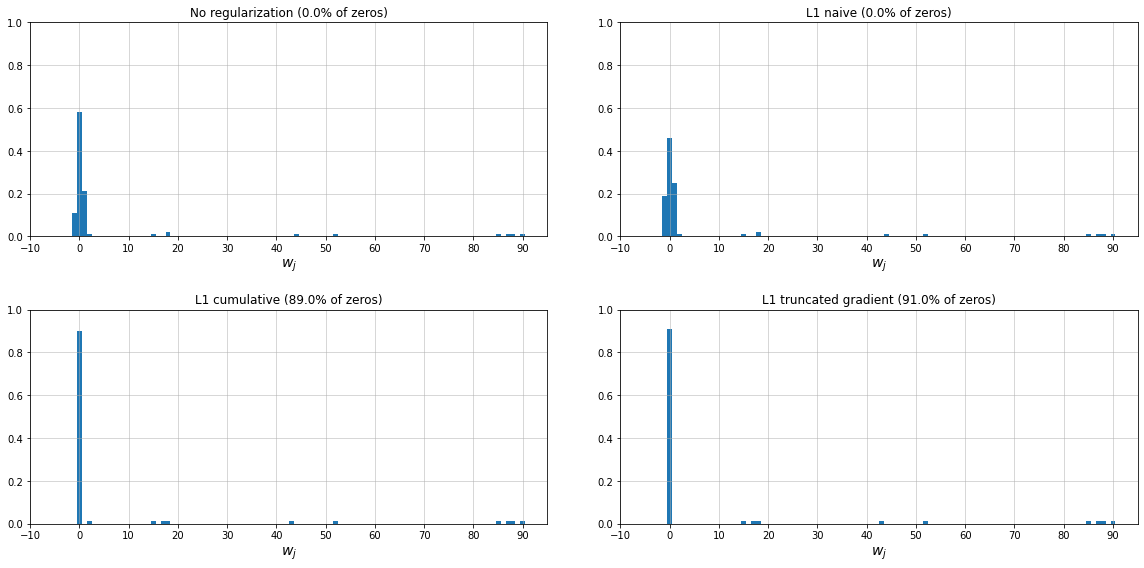

In [11]:
import numpy as np

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
axes = axes.ravel()

for ix, (method, weights) in enumerate(trained_weights.items()):
    zeros = weights.count(0) / len(weights) * 100
    axes[ix].hist(weights, density=True, bins=np.arange(-10.5, 95 + 1, 1))
    axes[ix].grid(linestyle='-', linewidth=0.5)
    axes[ix].set_title(f'{method} ({zeros:.1f}% of zeros)')
    axes[ix].set_xlabel(r'$w_j$', fontsize=14)
    axes[ix].set_xticks(np.arange(-10, 95 + 10, 10))
    axes[ix].set_xlim(-10, 95)
    axes[ix].set_ylim(0, 1)

fig.tight_layout(h_pad=2, w_pad=5)
plt.show()

| Method                | Hyper-parmameters                     | # of features | MAE |
|:----------------------|:--------------------------------------|--------------:|:---:|
| No regularization     |                                       |           100 | 8.2 |
| L1 naive              | $\lambda = 0.1$                       |           100 | 8,7 |
| L1 cumulative         | $\lambda = 0.1$                       |            11 | 6.7 |
| Truncated gradient    | $\lambda = 5$ &nbsp; $K=10$ &nbsp; $\theta = 3$ |             9 | 6.8 |